- breast cancer dataset(위스콘신 유방암 데이터) : 종양의 크기 , 모양 등 다양한 속성값으로 악성종양(malignant) 인지 양성종양(benign)인지 분류한 데이터 
- 종양의 다양한 피처에 따라 악성종양인지 일반 양성 종양인지를 XGBoost를 이용해 예측해보자

In [1]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, preds, pred_probs=None):
    mat = confusion_matrix(y_test,preds)
    acc = accuracy_score(y_test,preds)
    precision = precision_score(y_test,preds)
    recall = recall_score(y_test,preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test,preds)
    print('오차행렬 \n{}  \n정확도 : {:.3f} 정밀도 :{:.3f} 재현율 :{:.3f} f1 :{:.3f} auc:{:.3f}'.format(mat, acc,precision, recall,f1,auc))


#[실습] XGBoost using Python wrapper
- xgboost
- 정확도 : 0.956 

## 1. Data import and Check dataset
 - python wrapper xgboost 의 경우, DMatrix로 형태 변경

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore') 

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features,columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
# 0 : mailgnant / 1 : benign
print('target info : ', dataset.target_names)
print(cancer_df['target'].value_counts())

target info :  ['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# test dataset 20% / train dataset 80%
X_train, X_test, y_train, y_test= train_test_split(X_features, y_label, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


In [ ]:
# python wrapper xgboost 의 경우, DMatrix를 이용한다.
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
print(type(dtrain), type(dtest))

<class 'xgboost.core.DMatrix'> <class 'xgboost.core.DMatrix'>


##2. xgb 학습후 예측
-  train으로 학습시 train - error , eval-logloss는 지속적으로 감소한다.
-  predict결과값은 확률값으로 나옴
- 정확도 : 0.956 정밀도 :0.985 재현율 :0.943 f1 :0.964 auc:0.960

In [ ]:
params = {
    'max_depth' : 3,
    'eta' : 0.1,
    'objective'  : 'binary:logistic', # target이 0,1 이진분류이므로 binary logistic
    'eval_metric' :'logloss', 
    'early stopping':500 
}

num_rounds = 1000 # 부스팅 반복횟수는 400회

# train dataset은 'train' evaluation test dataset은 'eval'로 표기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain =dtrain , num_boost_round=num_rounds, early_stopping_rounds=500, evals=wlist)

[0]	train-logloss:0.609571	eval-logloss:0.612011
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 500 rounds.
[1]	train-logloss:0.541411	eval-logloss:0.549438
[2]	train-logloss:0.483286	eval-logloss:0.495781
[3]	train-logloss:0.435568	eval-logloss:0.448049
[4]	train-logloss:0.392154	eval-logloss:0.411764
[5]	train-logloss:0.353474	eval-logloss:0.376427
[6]	train-logloss:0.3209	eval-logloss:0.349805
[7]	train-logloss:0.292539	eval-logloss:0.322584
[8]	train-logloss:0.266347	eval-logloss:0.298739
[9]	train-logloss:0.243992	eval-logloss:0.280988
[10]	train-logloss:0.224376	eval-logloss:0.262922
[11]	train-logloss:0.205832	eval-logloss:0.247066
[12]	train-logloss:0.189968	eval-logloss:0.234151
[13]	train-logloss:0.176058	eval-logloss:0.221007
[14]	train-logloss:0.162803	eval-logloss:0.210084
[15]	train-logloss:0.151687	eval-logloss:0.199908
[16]	train-logloss:0.141012	eval-logloss:0.191516
[17]	train-l

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('예측결과를 10개만 표시; 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3)); print('='*50)

# 예측 확률 값이 0.5보다 크면 1 작으면 0
preds = pred_probs
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0
print('예측값 10개만 표시 : ',preds[:10]); print('='*50)

get_clf_eval(y_test,preds,pred_probs)

예측결과를 10개만 표시; 예측 확률 값으로 표시됨
[0.999 1.    0.999 1.    0.998 1.    0.005 1.    1.    1.   ]
예측값 10개만 표시 :  [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
오차행렬 
[[43  2]
 [ 0 69]]  
정확도 : 0.982 정밀도 :0.972 재현율 :1.000 f1 :0.986 auc:0.978


## 3. f1기반 각 피처별 중요도 확인
- xgboost 넘파이기반의 피처데이터로 학습 시에 피처명을 제대로 확인 할 수 없음 
- f0 : 0번째 feature/ f1 :1번째 feature 를 의미함 

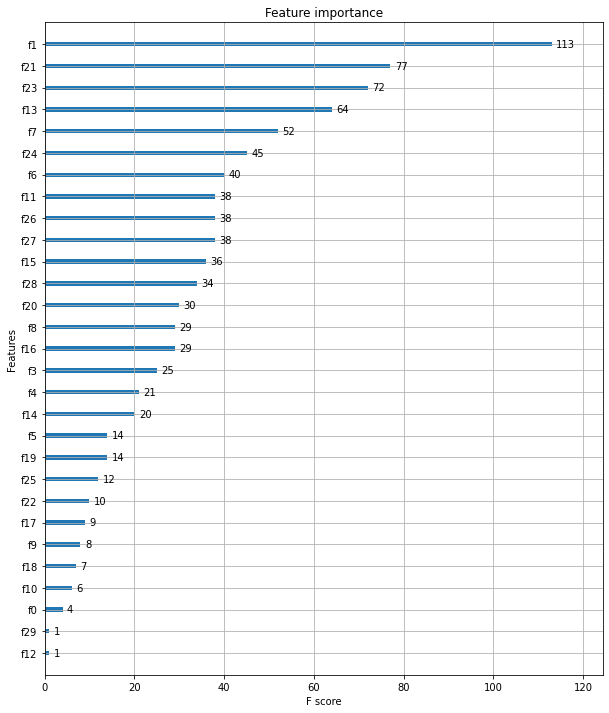

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

#[실습] XGBoost using sklearn wrapper
- XGBClassifier
- early stopping을 매우 작게 선택 할 경우, 충분한 학습이 되지않아 예측성능이 나빠질 수 있음
-정확도 : 0.965

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_pred = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_pred, w_pred_proba)

오차행렬 
[[43  2]
 [ 0 69]]  
정확도 : 0.982 정밀도 :0.972 재현율 :1.000 f1 :0.986 auc:0.978


In [ ]:
# early stopping을 적용해보자. (early_stopping_rounds=500)
xgb_wrapper= XGBClassifier(n_estimators=1000, learning_rate = 0.1, max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train, early_stopping_rounds=500, eval_metric='logloss', eval_set=evals , verbose=False)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

# early stopping을 적용해보자. (early_stopping_rounds=10)
xgb_wrapper.fit(X_train,y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals , verbose=False)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차행렬 
[[42  3]
 [ 2 67]]  
정확도 : 0.956 정밀도 :0.957 재현율 :0.971 f1 :0.964 auc:0.952
오차행렬 
[[42  3]
 [ 2 67]]  
정확도 : 0.956 정밀도 :0.957 재현율 :0.971 f1 :0.964 auc:0.952


##GridSearchCV를 통해 하이퍼파라미터를 구하고 학습후 예측하자.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 모델 생성
xgb_model = XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보입력(어떤 모델, 파라미터 후보, 교차검증 몇번)
grid_cv = GridSearchCV(xgb_model,param_grid=params, cv=3)

# 파라미터 튜닝 시작
grid_cv_fit = grid_cv.fit(X_train,y_train,early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_test,y_test)],verbose=False)

# 최적 파라미터 출력
print(grid_cv_fit.best_params_)

# 튜닝된 파라미터를 가지고 모델 생성
xgb_model = XGBClassifier(n_estimator=1000, learning_rate=0.02,max_depth=7, colsample_bytree=0.5, min_child_weight=1)

# 학습 
xgb_model.fit(X_train, y_train)

# 예측
pred = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)

{'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 1}
오차행렬 
[[43  2]
 [ 2 67]]  
정확도 : 0.965 정밀도 :0.971 재현율 :0.971 f1 :0.971 auc:0.963


# [실습] LightGBM using sklearn wrapper
- LGBClassfiler 
- 정확도 : 0.974 

feature type <class 'numpy.ndarray'>, target type <class 'numpy.ndarray'>
X_train (455, 30), X_test (114, 30), y_train (455,),y_test (114,)
오차행렬 
[[34  3]
 [ 4 73]]  
정확도 : 0.939 정밀도 :0.961 재현율 :0.948 f1 :0.954 auc:0.933


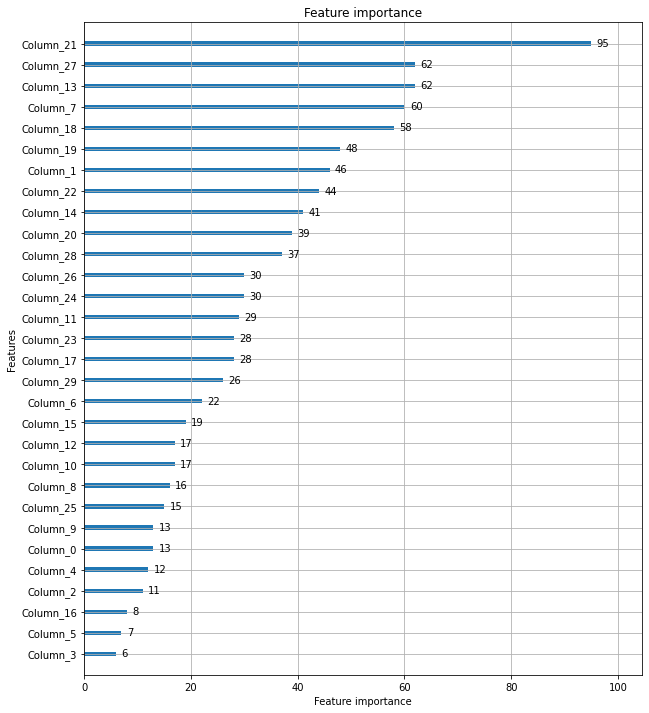

In [ ]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
feature = dataset.data
target = dataset.target
print('feature type {}, target type {}'.format(type(feature), type(target)));print('='*50)

# trainset 80% testset 20% 로 분할
X_train, X_test, y_train,y_test = train_test_split(feature, target, test_size=0.2)
print('X_train {}, X_test {}, y_train {},y_test {}'.format(X_train.shape, X_test.shape, y_train.shape,y_test.shape));print('='*50)

# 앞서 XGBoost와 동일하게 n_estimator 400으로 선정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 early stopping 지정 후 , 학습
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=False)

# 예측
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)

# evaluation
get_clf_eval(y_test,pred,pred_proba)
print('='*50)

# plot_importacne()를 이용해 피처 중요도 시각화
fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)


# [실습] Stacking
- 개별모델 : KNN , RandomForest, DecisionTree, Adaboost
    * knn 정확도 : 0.947 정밀도 :0.944 재현율 :0.971 f1 :0.958 auc:0.940
    * rf 정확도 : 0.965 정밀도 :0.971 재현율 :0.971 f1 :0.971 auc:0.963
    * ada 정확도 : 0.991 정밀도 :0.986 재현율 :1.000 f1 :0.993 auc:0.989
    * dt 정확도 : 0.965 정밀도 :0.958 재현율 :0.986 f1 :0.972 auc:0.959
- 최종모델 : Logistic Regression
    * 정확도 : 0.982 정밀도 :0.972 재현율 :1.000 f1 :0.986 auc:*0.977*

- **adaboost 결과가 매우 좋았던 터라 최종모델이 개별 모델 보다 예측성능이 낮은 결과를 확인 할 수 있다. (stacking을 적용한다고 항상 예측성능이 개선되는 것이 아님을 확인)**

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_data = dataset.data
y_label = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


## 개별 모델 생성 / 학습 / 예측

In [ ]:
# 개별 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100)
ada_clf = AdaBoostClassifier(n_estimators=100)
dt_clf = DecisionTreeClassifier()

# 개별 모델을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)

# 개별 모델을 예측 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)

print('knn 정확도 : \n')
get_clf_eval(y_test,knn_pred); print('='*50)
print('rf 정확도 : \n')
get_clf_eval(y_test,rf_pred); print('='*50)
print('ada 정확도 : \n')
get_clf_eval(y_test,ada_pred); print('='*50)
print('dt 정확도 : \n')
get_clf_eval(y_test,dt_pred); print('='*50)


knn 정확도 : 

오차행렬 
[[40  4]
 [ 2 68]]  
정확도 : 0.947 정밀도 :0.944 재현율 :0.971 f1 :0.958 auc:0.940
rf 정확도 : 

오차행렬 
[[42  2]
 [ 2 68]]  
정확도 : 0.965 정밀도 :0.971 재현율 :0.971 f1 :0.971 auc:0.963
ada 정확도 : 

오차행렬 
[[43  1]
 [ 0 70]]  
정확도 : 0.991 정밀도 :0.986 재현율 :1.000 f1 :0.993 auc:0.989
dt 정확도 : 

오차행렬 
[[41  3]
 [ 1 69]]  
정확도 : 0.965 정밀도 :0.958 재현율 :0.986 f1 :0.972 auc:0.959


## 예측한 값을 쌓은 후 최종 모델을 활용해 학습/예측

In [ ]:
pred =np.array([knn_pred, rf_pred, ada_pred, dt_pred])
print(pred.shape)
# transpose를 이용해 각 알고리즘의 예측결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape);print('='*50)

# 스태킹으로 만들어진 데이터세트를 학습, 예측할 최종모델 생성
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(pred, y_test)
lr_pred = lr_clf.predict(pred)
print('최종 메타모델의 예측 정확도:')
get_clf_eval(y_test,lr_pred)

(4, 114)
(114, 4)
최종 메타모델의 예측 정확도:
오차행렬 
[[42  2]
 [ 0 70]]  
정확도 : 0.982 정밀도 :0.972 재현율 :1.000 f1 :0.986 auc:0.977


# [실습] CV 세트 기반 Stacking
- 교차 검증 기반으로 예측된 결과 데이터 세트를 이용
- 정확도 : 0.956 정밀도 :0.962 재현율 :0.974 f1 :0.968 auc:0.946



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 모델에서 최종메타모델이 사용할 학습/테스트 데이터를 생성하는 함수
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__, 'model start')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        # print('폴드세트 : ',folder_counter, ' start')
        x_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 모델 학습
        model.fit(x_tr,y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 예측후 저장
        train_fold_pred[valid_index,:]= model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 저장.
        test_pred[:,folder_counter] = model.predict(X_test_n)
    # 폴드 세트 내에서  원본테스트 데이터를 예측한데이터 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # 최종 메타 모델이 사용하는 학습데이터 / 테스트데이터 리턴
    return train_fold_pred, test_pred_mean


In [ ]:
# 개별 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100)
ada_clf = AdaBoostClassifier(n_estimators=100)
dt_clf = DecisionTreeClassifier()

# 개별 모델 별 train/test dataset 생성
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train,X_test,7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train,X_test,7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train,X_test,7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train,X_test,7)

# 메타모델이 사용할 train/test dataset 생성 (피처 = 모델 수)
stack_final_x_train = np.concatenate((knn_train,rf_train,ada_train,dt_train),axis=1)
stack_final_x_test = np.concatenate((knn_test,rf_test,ada_test,dt_test),axis=1)
print('='*50)
print('원본 train shape', X_train.shape, 'test shape', X_test.shape)
print('스태킹 train shape', stack_final_x_train.shape, 'test shape', stack_final_x_test.shape); print('='*50)

# 최종 메타모델로 학습 /예측 / 평가
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(stack_final_x_train,y_train)
lr_pred = lr_clf.predict(stack_final_x_test)
print('최종 메타모델의 예측정확도')
get_clf_eval(y_test,lr_pred)

KNeighborsClassifier model start
RandomForestClassifier model start
AdaBoostClassifier model start
DecisionTreeClassifier model start
원본 train shape (455, 30) test shape (114, 30)
스태킹 train shape (455, 4) test shape (114, 4)
최종 메타모델의 예측정확도
오차행렬 
[[34  3]
 [ 2 75]]  
정확도 : 0.956 정밀도 :0.962 재현율 :0.974 f1 :0.968 auc:0.946


# [실습] Logistic Regression

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

# scaling 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.data)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y_label, test_size=0.3)
print('shape :', X_train.shape, X_test.shape, y_train.shape, y_test.shape);print('='*50)

# 학습 / 예측 / 평가
model = LogisticRegression(solver='liblinear')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
get_clf_eval(y_pred, y_test)
print('='*50)

# hyperparameter turning
params = {
          'penalty' : ['l1','l2'],
          'C' : [0.01,0.1,1,5,10]
}
grid_clf = GridSearchCV(model,param_grid=params,cv=5,scoring='accuracy')
grid_clf.fit(X_train,y_train)
print('최적 파라미터:\n', grid_clf.best_params_)
print('최적 정확도:\n', grid_clf.best_score_)
print('='*50)


shape : (398, 30) (171, 30) (398,) (171,)
오차행렬 
[[ 66   1]
 [  4 100]]  
정확도 : 0.971 정밀도 :0.990 재현율 :0.962 f1 :0.976 auc:0.973
최적 파라미터:
 {'C': 5, 'penalty': 'l2'}
최적 정확도:
 0.9799050632911392


array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])